<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/%ED%95%98%EC%9D%B4%EB%8B%89%EC%8A%A4_%ED%86%B5%ED%95%A9%ED%85%8C%EC%9D%B4%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘 시작

## 라이브러리 설치

In [1]:
!pip install finance-datareader
!pip install pykrx
!pip install pymysql
!pip install konlpy
from konlpy.tag import Okt
okt = Okt()

     |████████████████████████████████| 70 kB 5.5 MB/s 
     |████████████████████████████████| 60 kB 6.9 MB/s 
     |████████████████████████████████| 251 kB 41.9 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 19.4 MB 1.5 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 448 kB 44.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## 패키지 & 함수 로딩

In [2]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [3]:
def money_sur(stock_name, start, end):

    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

In [4]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min())) + org_x_np.min()

## 통합테이블 생성

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# total_table = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/total_table.csv') # 기존 테이블

In [7]:
# 구성
dic = {'code' : [],
       'date' : [],
       'lstm' : [],
       'arima' : [],
       'fbprophet' : [],
       'RL' : [],
    #    'mail_news' : [],
    #    'mail_news_nsi' : [],
    #    'asia_news' : [],
    #    'asia_news_nsi': [],
    #    'youtube_sam' : [],
    #    'youtube_su' : [],
    #    'youtube_han' : [],
       'close' : []}

total_table = pd.DataFrame(dic)

In [8]:
total_table.columns

Index(['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'close'], dtype='object')

In [9]:
total_table

,code,date,lstm,arima,fbprophet,RL,close


## LSTM 예측결과

### 사용 데이터 로드 및 전처리

In [10]:
# start_date = (datetime.datetime.now() - datetime.timedelta(40)).strftime("%Y%m%d")
end_date = datetime.datetime.now().strftime("%Y%m%d")
lstm = money_sur('000660', '2018', end_date)

In [11]:
lstm = lstm.set_index('Date')

In [12]:
lstm.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,77300,77300,76200,76600,2014838,0.001307,32990,18.31,2.32,4184,0.78,600
2018-01-03,78100,78800,77300,77700,3097644,0.014360,32990,18.57,2.36,4184,0.77,600
2018-01-04,78700,79700,77100,77100,3729328,-0.007722,32990,18.43,2.34,4184,0.78,600
2018-01-05,78400,79400,78300,79300,3395065,0.028534,32990,18.95,2.40,4184,0.76,600
2018-01-08,79500,80000,77400,78200,2960495,-0.013871,32990,18.69,2.37,4184,0.77,600


In [13]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
lstm_sc = sc.fit_transform(lstm)

In [14]:
scale_cols = lstm.columns
lstm_sc_df = pd.DataFrame(lstm_sc, columns=[scale_cols], index=lstm.index)

In [15]:
lstm_sc_df.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,0.216393,0.204348,0.227273,0.208150,0.045916,0.409709,0.0,0.324864,0.757062,0.064261,0.069767,0.0
2018-01-03,0.225137,0.220652,0.240093,0.220264,0.106204,0.467774,0.0,0.330323,0.779661,0.064261,0.063953,0.0
2018-01-04,0.231694,0.230435,0.237762,0.213656,0.141375,0.369543,0.0,0.327383,0.768362,0.064261,0.069767,0.0
2018-01-05,0.228415,0.227174,0.251748,0.237885,0.122764,0.530825,0.0,0.338303,0.802260,0.064261,0.058140,0.0
2018-01-08,0.240437,0.233696,0.241259,0.225771,0.098568,0.342189,0.0,0.332843,0.785311,0.064261,0.063953,0.0


In [16]:
for i in scale_cols:
  for s in range(1, 11):  
    lstm_sc_df[(i+'shift_{}'.format(s),)] = lstm_sc_df[(i,)].shift(s)

In [17]:
lstm_sc_df.dropna()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,...,PBRshift_1,PBRshift_2,PBRshift_3,PBRshift_4,PBRshift_5,PBRshift_6,PBRshift_7,PBRshift_8,PBRshift_9,PBRshift_10,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-16,0.166120,0.176087,0.186480,0.183921,0.177783,0.507913,0.0,0.313734,0.723164,0.064261,0.087209,0.000000,0.177049,0.172678,0.171585,0.209836,0.227322,0.240437,0.228415,0.231694,0.225137,0.216393,0.169565,0.173913,0.166304,0.197826,0.221739,0.233696,0.227174,0.230435,0.220652,0.204348,0.184149,0.178322,0.178322,0.184149,0.228438,0.241259,0.251748,0.237762,...,0.689266,0.723164,0.689266,0.694915,0.762712,0.785311,0.802260,0.768362,0.779661,0.757062,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.098837,0.087209,0.098837,0.093023,0.069767,0.063953,0.058140,0.069767,0.063953,0.069767,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-17,0.184699,0.179348,0.198135,0.180617,0.115056,0.385957,0.0,0.312264,0.717514,0.064261,0.087209,0.000000,0.166120,0.177049,0.172678,0.171585,0.209836,0.227322,0.240437,0.228415,0.231694,0.225137,0.176087,0.169565,0.173913,0.166304,0.197826,0.221739,0.233696,0.227174,0.230435,0.220652,0.186480,0.184149,0.178322,0.178322,0.184149,0.228438,0.241259,0.251748,...,0.723164,0.689266,0.723164,0.689266,0.694915,0.762712,0.785311,0.802260,0.768362,0.779661,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.087209,0.098837,0.087209,0.098837,0.093023,0.069767,0.063953,0.058140,0.069767,0.063953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-18,0.200000,0.198913,0.208625,0.192731,0.278926,0.469929,0.0,0.317724,0.734463,0.064261,0.081395,0.000000,0.184699,0.166120,0.177049,0.172678,0.171585,0.209836,0.227322,0.240437,0.228415,0.231694,0.179348,0.176087,0.169565,0.173913,0.166304,0.197826,0.221739,0.233696,0.227174,0.230435,0.198135,0.186480,0.184149,0.178322,0.178322,0.184149,0.228438,0.241259,...,0.717514,0.723164,0.689266,0.723164,0.689266,0.694915,0.762712,0.785311,0.802260,0.768362,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.087209,0.087209,0.098837,0.087209,0.098837,0.093023,0.069767,0.063953,0.058140,0.069767,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-19,0.194536,0.188043,0.189977,0.171806,0.150789,0.291502,0.0,0.308274,0.700565,0.064261,0.093023,0.000000,0.200000,0.184699,0.166120,0.177049,0.172678,0.171585,0.209836,0.227322,0.240437,0.228415,0.198913,0.179348,0.176087,0.169565,0.173913,0.166304,0.197826,0.221739,0.233696,0.227174,0.208625,0.198135,0.186480,0.184149,0.178322,0.178322,0.184149,0.228438,...,0.734463,0.717514,0.723164,0.689266,0.723164,0.689266,0.694915,0.762712,0.785311,0.802260,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.081395,0.087209,0.087209,0.098837,0.087209,0.098837,0.093023,0.069767,0.063953,0.058140,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-22,0.167213,0.155435,0.163170,0.147577,0.246113,0.270382,0.0,0.297144,0.666667,0.064261,0.104651,0.000000,0.194536,0.200000,0.184699,0.166120,0.17704

In [18]:
X_test = lstm_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = lstm_sc_df.dropna()[['Close']]

X_test= X_test.values
y_test = y_test.values

In [19]:
X_test

array([[0.17704918, 0.1726776 , 0.1715847 , ..., 0.        , 0.        ,
        0.        ],
       [0.16612022, 0.17704918, 0.1726776 , ..., 0.        , 0.        ,
        0.        ],
       [0.18469945, 0.16612022, 0.17704918, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.47540984, 0.51912568, 0.50819672, ..., 0.63333333, 0.63333333,
        0.63333333],
       [0.46338798, 0.47540984, 0.51912568, ..., 0.63333333, 0.63333333,
        0.63333333],
       [0.4863388 , 0.46338798, 0.47540984, ..., 0.63333333, 0.63333333,
        0.63333333]])

In [20]:
X_test_t = X_test.reshape(X_test.shape[0], 10, 12)

### 모델 로드

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda,Dropout, Flatten
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dense(32, activation = 'tanh'))
model.add(Flatten())
model.add(Dense(1))


lstm_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/LSTM/'
hy_lstm = 'lstm_hy.h5'

model.load_weights(lstm_path+hy_lstm)

### 모델 결과

In [22]:
pred = model.predict(X_test_t)

In [23]:
pred.shape, y_test.shape

((915, 1), (915, 1))

In [24]:
pred_act = reverse_min_max_scaling(lstm['Close'], pred)

In [25]:
total_table['date'] = lstm.index[10:]
total_table['lstm'] = pred_act[:]
total_table['close'] = lstm.Close[10:].values.reshape(-1,1)
total_table['code'] = '000660'
total_table['change'] = lstm.Change[10:].values.reshape(-1,1)

In [26]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,000660,2018-01-16,75241.874659,NaN,NaN,NaN,74400,0.023384
1,000660,2018-01-17,76052.745509,NaN,NaN,NaN,74100,-0.004032
2,000660,2018-01-18,74820.806378,NaN,NaN,NaN,75200,0.014845
3,000660,2018-01-19,77132.174319,NaN,NaN,NaN,73300,-0.025266
4,000660,2018-01-22,74366.525382,NaN,NaN,NaN,71100,-0.030014
...,...,...,...,...,...,...,...,...
910,000660,2021-09-28,107043.387222,NaN,NaN,NaN,103500,-0.009569
911,000660,2021-09-29,107021.111012,NaN,NaN,NaN,100000,-0.033816
912,000660,2021-09-30,102079.786348,NaN,NaN,NaN,103000,0.030000
913,000660,2021-10-01,104292.145300,NaN,NaN,NaN,100000,-0.029126


## arima 예측결과

In [27]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('000660', '2000', end_date)

In [28]:
df = samsung_df[['Date','Close']]
df.columns = ['Date', 'Price']

In [29]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# 학습, 테스트 데이터 분리
for ru in range(-len(total_table),0):
    rus = ru+1
    train = df[:ru]
    test = df[ru:]

    model = ARIMA(train.Price.values, order = (2,1,2))
    model_fit = model.fit(trend = 'nc', full_output = True, disp = True)

    fore = model_fit.forecast(steps=1) # 오늘 예측

    # 오늘 예측 데이터
    pred_arima_y = fore[0].tolist()

    # # 신뢰구간
    # # 예측 데이터 최소값
    # pred_y_lower = []
    # # 예측 데이터 최대값
    # pred_y_upper = []

    # for lower_upper in fore[2]:
    #     lower = lower_upper[0]
    #     upper = lower_upper[1]
    #     pred_y_lower.append(lower)
    #     pred_y_upper.append(upper)
    if rus == 0:
        total_table['arima'].iloc[ru:] = pred_arima_y
    else:
        total_table['arima'].iloc[ru:rus] = pred_arima_y

print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5369
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -52742.723
Method:                       css-mle   S.D. of innovations           4467.496
Date:                Tue, 05 Oct 2021   AIC                         105495.446
Time:                        04:38:57   BIC                         105528.388
Sample:                             1   HQIC                        105506.950
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y     -0.6878      0.007    -94.711      0.000      -0.702      -0.674
ar.L2.D.y     -0.9650      0.009   -102.592      0.000      -0.983      -0.947
ma.L1.D.y      0.7075      0.011     63.520      0.0

In [30]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,000660,2018-01-16,75241.874659,72542.553995,NaN,NaN,74400,0.023384
1,000660,2018-01-17,76052.745509,74485.153086,NaN,NaN,74100,-0.004032
2,000660,2018-01-18,74820.806378,74115.115203,NaN,NaN,75200,0.014845
3,000660,2018-01-19,77132.174319,75145.988383,NaN,NaN,73300,-0.025266
4,000660,2018-01-22,74366.525382,73241.207488,NaN,NaN,71100,-0.030014
...,...,...,...,...,...,...,...,...
910,000660,2021-09-28,107043.387222,104730.352102,NaN,NaN,103500,-0.009569
911,000660,2021-09-29,107021.111012,103212.455833,NaN,NaN,100000,-0.033816
912,000660,2021-09-30,102079.786348,99956.289857,NaN,NaN,103000,0.030000
913,000660,2021-10-01,104292.145300,103483.507739,NaN,NaN,100000,-0.029126


## fbprophet 예측

In [31]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('000660', start = '20180101', end = end_date)
df1 = samsung_df[['Date','Close']]
df1.columns = ['ds', 'y']

from fbprophet import Prophet

prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.6)

prophet.fit(df1)

# 10일단위로 예측값을 가져옴
future_data = prophet.make_future_dataframe(periods = 10, freq = 'd')
forecast_data = prophet.predict(future_data)

In [32]:
list(total_table.date.values)

[numpy.datetime64('2018-01-16T00:00:00.000000000'),
 numpy.datetime64('2018-01-17T00:00:00.000000000'),
 numpy.datetime64('2018-01-18T00:00:00.000000000'),
 numpy.datetime64('2018-01-19T00:00:00.000000000'),
 numpy.datetime64('2018-01-22T00:00:00.000000000'),
 numpy.datetime64('2018-01-23T00:00:00.000000000'),
 numpy.datetime64('2018-01-24T00:00:00.000000000'),
 numpy.datetime64('2018-01-25T00:00:00.000000000'),
 numpy.datetime64('2018-01-26T00:00:00.000000000'),
 numpy.datetime64('2018-01-29T00:00:00.000000000'),
 numpy.datetime64('2018-01-30T00:00:00.000000000'),
 numpy.datetime64('2018-01-31T00:00:00.000000000'),
 numpy.datetime64('2018-02-01T00:00:00.000000000'),
 numpy.datetime64('2018-02-02T00:00:00.000000000'),
 numpy.datetime64('2018-02-05T00:00:00.000000000'),
 numpy.datetime64('2018-02-06T00:00:00.000000000'),
 numpy.datetime64('2018-02-07T00:00:00.000000000'),
 numpy.datetime64('2018-02-08T00:00:00.000000000'),
 numpy.datetime64('2018-02-09T00:00:00.000000000'),
 numpy.datet

In [33]:
total_table['fbprophet'] = forecast_data[forecast_data['ds'].isin(list(total_table.date.values))]['yhat'].values

In [34]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,000660,2018-01-16,75241.874659,72542.553995,74889.973285,NaN,74400,0.023384
1,000660,2018-01-17,76052.745509,74485.153086,74673.030972,NaN,74100,-0.004032
2,000660,2018-01-18,74820.806378,74115.115203,74647.438730,NaN,75200,0.014845
3,000660,2018-01-19,77132.174319,75145.988383,74481.004025,NaN,73300,-0.025266
4,000660,2018-01-22,74366.525382,73241.207488,73765.619053,NaN,71100,-0.030014
...,...,...,...,...,...,...,...,...
910,000660,2021-09-28,107043.387222,104730.352102,102359.063572,NaN,103500,-0.009569
911,000660,2021-09-29,107021.111012,103212.455833,101925.958867,NaN,100000,-0.033816
912,000660,2021-09-30,102079.786348,99956.289857,101804.451328,NaN,103000,0.030000
913,000660,2021-10-01,104292.145300,103483.507739,101463.377500,NaN,100000,-0.029126


In [35]:
# total_table.to_csv('./total_table.csv', index =False)

## RL 결과

### 데이터 로딩 및 함수 로딩

In [36]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

# 금융정보 조회하기
def dataset_loaderKR(stock_name, start, end, train_ratio=0.8):
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')
    date_split = data.index[int(train_ratio*len(data))] 

    return data[:date_split], data[date_split:], date_split


# ENV 설정
class Environment1:
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs

    def step(self, act):
        reward = 0
        
        # action
        # 0: Idle
        # 1: 매수
        # 2: 매도
        if act == 1: #매수
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # 매도
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

# MODEL
class Q_Network(nn.Module):
    def __init__(self,obs_len,hidden_size,actions_n):
        super(Q_Network,self).__init__()
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
    def forward(self,x):
        h = self.fc_val(x)
        return (h)

In [37]:
(train, test, date_split) = dataset_loaderKR('000660', start = '2000', end = end_date)

### 모델 로딩 및 결과

In [38]:
rl_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/RL/하이닉스_결과/'
hy_rl = 'hynix_rl_재무정보.h5'

In [39]:
# 모델 로딩
model = torch.load(rl_path+hy_rl)

test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs

# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]


print( )
print( test )
print( )
print("결과")
print( "손익결과 $%.2f" % round(test_profits,2) )
# 0: Idle
# 1: 매수
# 2: 매도


           Date    Open    High     Low   Close  ...   PBR   EPS   DIV   DPS  Action
4296 2017-05-22   54900   56000   54800   56000  ...  1.70  4184  1.07   600       1
4297 2017-05-23   56400   56500   55000   55100  ...  1.67  4184  1.09   600       0
4298 2017-05-24   55700   56500   55600   55800  ...  1.69  4184  1.08   600       2
4299 2017-05-25   56400   56400   55400   55800  ...  1.69  4184  1.08   600       1
4300 2017-05-26   56000   57100   56000   57100  ...  1.73  4184  1.05   600       2
...         ...     ...     ...     ...     ...  ...   ...   ...   ...   ...     ...
5366 2021-09-28  105000  105500  103000  103500  ...  1.45  6952  1.13  1170       2
5367 2021-09-29  101000  102000   99700  100000  ...  1.40  6952  1.17  1170       0
5368 2021-09-30   99900  103500   99600  103000  ...  1.45  6952  1.14  1170       0
5369 2021-10-01  102000  102500  100000  100000  ...  1.40  6952  1.17  1170       0
5370 2021-10-05   98900   99500   97200   97700  ...  1.37  6952

In [40]:
test['Action'] = np.where(test['Action'] == 1,1,
                          np.where(test['Action'] == 2,-1,0))

In [41]:
test['Action'][-10:]

5361   -1
5362    0
5363   -1
5364    1
5365    1
5366   -1
5367    0
5368    0
5369    0
5370    1
Name: Action, dtype: int64

In [42]:
total_table['RL'] = test[test['Date'].isin(list(total_table.date.values))]['Action'].values

In [43]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,000660,2018-01-16,75241.874659,72542.553995,74889.973285,1,74400,0.023384
1,000660,2018-01-17,76052.745509,74485.153086,74673.030972,-1,74100,-0.004032
2,000660,2018-01-18,74820.806378,74115.115203,74647.438730,1,75200,0.014845
3,000660,2018-01-19,77132.174319,75145.988383,74481.004025,1,73300,-0.025266
4,000660,2018-01-22,74366.525382,73241.207488,73765.619053,-1,71100,-0.030014
...,...,...,...,...,...,...,...,...
910,000660,2021-09-28,107043.387222,104730.352102,102359.063572,-1,103500,-0.009569
911,000660,2021-09-29,107021.111012,103212.455833,101925.958867,0,100000,-0.033816
912,000660,2021-09-30,102079.786348,99956.289857,101804.451328,0,103000,0.030000
913,000660,2021-10-01,104292.145300,103483.507739,101463.377500,0,100000,-0.029126


## News 긍부정 결과
- '매일경제', '아시아경제'

In [44]:
# corp_list = ['samsung', 'hyundai', 'lg', 'sk', 'celltrion'] 참고용
stock_num_list = ['005930', '005380', '051910', '000660', '068270']
news = ['maeil_news_craw', 'asia_news_craw']
start = (datetime.datetime.now() - datetime.timedelta(20)).strftime("%Y-%m-%d").replace('-','')
end = datetime.datetime.now().strftime("%Y-%m-%d").replace('-', '')

In [45]:
# news_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/Final Data/1. samsung_score.csv') # 연습용

### 관련 함수 및 패키지 로드

In [46]:
import pymysql
import sys
import re

In [47]:
# 블로그에서 가져온 기본적인 한국어 긍부정 텍스트 목록
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/positive_words_self.txt', encoding='utf-8') as pos_blog:
    positive_blog = pos_blog.readlines()
positive_blog = [pos_blog.replace('\n', '') for pos_blog in positive_blog]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/negative_words_self.txt', encoding='utf-8') as neg_blog:
    negative_blog = neg_blog.readlines()
negative_blog = [neg_blog.replace('\n', '') for neg_blog in negative_blog]

# KOSELF 감성 어휘 사전
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_pos.txt', encoding='utf-8') as pos:
    positive = pos.readlines()
positive = [pos.replace('\n', '') for pos in positive]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_neg.txt', encoding='utf-8') as neg:
    negative = neg.readlines()
negative = [neg.replace('\n', '') for neg in negative]

In [48]:
def news_db(news, stock):
    db = pymysql.connect(
            user='root', 
            passwd='1234', 
            host='3.35.70.166', 
            db='proj', 
            charset = 'utf8'
        )

    cursor = db.cursor(pymysql.cursors.DictCursor)
    news1 = news + '_news_craw'

    sql = "select * from {0}_{1} where length(date)=10".format(news1, stock)
    cursor.execute(sql)
    result = cursor.fetchall()

    # DataFrame으로 변경
    df = pd.DataFrame(result)

    db.close()

    df.rename(columns={'date': 'datetime'}, inplace=True)

    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df['date'] = df['datetime'].str[0:4] + '-' + df['datetime'].str[4:6] + '-' + df['datetime'].str[6:8]
    df['date'] = pd.to_datetime(df['date'])

    # 결측치 제거 → 데이터 로드 시 완료했기 때문에 그다지 필요하지 않은 과정
    df = df.dropna()

    # 시간순으로 정렬
    df.sort_values('datetime', inplace=True)
    df.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)

    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
    stopwords = list(pd.read_csv(url, header=None)[0])

    # Stop Words List에 각 매체명 추가
    except_media_list = ['매일경제', '매일', '경제', 'maeil', 'MK', 'mk',
                         '아시아경제', '아시아', 'Asia', 'ASIA', 'asia',
                         '삼프로TV', '삼프로', 'TV',
                         '슈카월드', '슈카', '월드'
                         '한국경제TV', '한국']
    for word in except_media_list:
        stopwords.append(word)
    
    #### 2. Preprocessing
    '''감성 어휘 사전 : negative / positive
       뉴스 데이터 : samsung / hyundai / lg / sk
       주식 데이터 : stock_samsung / stock_hyundai / stock_lg / stock_sk
       공휴일 데이터 : holidays'''
    
    
    ### 1) 뉴스 데이터 날짜 조정
    
    ## 1-1)업로드 시각 컬럼 추가
    df['time'] = df['datetime'].str[-2:]
    
    ## 1-2) 전일 15시 ~ 금일 15시로 날짜 조정
    after_market = ['15', '16', '17', '18', '19', '20', '21', '22', '23']

    for j in range(len(df['time'])):
        if df['time'][j] in after_market:
            df['date'][j] += datetime.timedelta(1)
        else:
            pass
    
    ## 1-3) 텍스트 전처리
    # \n, \t, \r 제거
    df['text'] = df['text'].str.replace('[\n|\t|\r]', '')
    df['text'] = df['text'].str.replace('\[|\]', '')
    df['text'] = df['text'].str.replace('\<.*\>', '')
    df['text'] = df['text'].str.replace('\\', '')
    df['text'] = df['text'].str.replace('이미지', '')


    ### 2) 주말 및 공휴일 제외
    
    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df[df['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df[df['date'].isin(market_closed_list)]['date'].index:
            df['date'][hoil] += datetime.timedelta(1)
    
    ### 3) Tokenization 컬럼 추가
    
    df['Tokenization'] = 0
    rows = df.shape[0]
    for row in range(rows):
        hangeul = re.compile('[^ ㄱ-ㅣ 가-힣]')                                    # 정규 표현식 → 한글 추출 규칙 : 띄어쓰기(1개)를 포함한 한글
        result = hangeul.sub('', df['text'][row])   # 위에 설정한 hangeul 규칙을 text에 적용
        okt = Okt()                                                               # 형태소 추출
        nouns = okt.nouns(df['text'][row])
        nouns = [x for x in nouns if len(x) > 1]                                  # 한 글자 키워드 제거
        nouns = [x for x in nouns if x not in stopwords]                          # 불용어 제거
        
        corpus = " ".join(nouns)                                                  # List를 String으로 변환
        df['Tokenization'][row] = corpus


    # 점수 산출

    df['Positive_Score'] = 0
    df['Negative_Score'] = 0
    df['Ratio'] = 0.1
    df['Pred'] = 0
    df['NSI'] = 0.1
    
    for score in range(len(df)):
        pos_score = 0 ; neg_score = 0
        
        for token in range(len(df['Tokenization'][score].split())):
            if df['Tokenization'][score].split()[token] in positive:
                pos_score += 1
            elif df['Tokenization'][score].split()[token] in negative:
                neg_score += 1
            else:
                pass
        
        df['Positive_Score'][score] = pos_score
        df['Negative_Score'][score] = neg_score
        
        # 긍정과 부정의 비율
        if (pos_score==0) and (neg_score==0):
            df['Ratio'][score] = 0.5   # 둘 다 0일 경우에는 긍정으로 가정
        else:
            df['Ratio'][score] = pos_score / (pos_score + neg_score)
        
        # 예측 결과
        if df['Ratio'][score]>=0.5:
            df['Pred'][score] = 1
        else:
            df['Pred'][score] = -1
        
        # 뉴스심리지수(NSI) 계산
        if (pos_score==0) and (neg_score==0):
            df['NSI'][score] = 101
        else:
            df['NSI'][score] = (pos_score - neg_score) / (pos_score + neg_score) * 100 + 100
    
    return df

### 매일경제

In [49]:
# mail_df = news_df[(news_df['news'] == '매일경제') & (news_df['st_cd'] == 5930)]

In [50]:
mail_df = news_db('maeil', '000660')

In [51]:
mail_df.head()

,st_n,st_cd,news,datetime,title,url,text,date,time,Tokenization,Positive_Score,Negative_Score,Ratio,Pred,NSI
0,sk하이닉스,000660,매일경제,2018010100,"동원산업·휠라코리아 ""생큐 트럼프""",http://news.mk.co.kr/newsRead.php?year=2018&no=30,■ 2018 美법인세인하 수혜株 올해 1월부터 법인세 인하를 골자로 한 미국 세제...,2018-01-02,00,법인세 인하 수혜 올해 법인세 인하 골자 미국 세제 개혁 법안 현실 국내 증시 관련...,3,1,0.750000,1,150.000000
1,sk하이닉스,000660,매일경제,2018010104,"[2018 국내 업종별 전망] 반도체, D램 독주 계속…`반도체 정점론` 부담",http://news.mk.co.kr/newsRead.php?year=2018&no...,인공지능(AI) 사물인터넷(IoT) 등 4차 산업혁명 수요 폭발에 따른 슈퍼 사이...,2018-01-02,04,인공 지능 사물인터넷 산업혁명 수요 폭발 슈퍼 사이클 효자 역할 반도체 산업 올해 ...,0,0,0.500000,1,101.000000
2,sk하이닉스,000660,매일경제,2018010104,[2018 경제기상도] `1월효과` 기대 커진 증시…반도체·바이오株 계속 달릴듯,http://news.mk.co.kr/newsRead.php?year=2018&no...,지난해 연말 조정장세는 올해 초 코스피와 코스닥시장 '1월 효과'의 기폭제가 될 ...,2018-01-02,04,지난해 연말 정장 올해 코스피 코스닥시장 효과 폭제 전망 장사 실적 단기 급상승 우...,8,4,0.666667,1,133.333333
3,sk하이닉스,000660,매일경제,2018010117,電·車 CEO 라스베이거스 출동,http://news.mk.co.kr/newsRead.php?year=2018&no...,새해 벽두부터 국내 주요 기업 최고경영자(CEO)가 미국 라스베이거스에 대거 집결...,2018-01-02,17,새해 벽두 국내 주요 기업 최고경영자 미국 라스베이거스 대거 집결 세계 최대 가전 ...,0,0,0.500000,1,101.000000
4,sk하이닉스,000660,매일경제,2018010200,"美기업, 삼성전자·SK하이닉스 겨냥 반도체특허 소송 제기",http://news.mk.co.kr/newsRead.php?year=2018&no...,◆ 2018년 신년기획 / 새해도 수출이다 ◆미국 반도체 기업인 '비트마이크로(Bi...,2018-01-02,00,신년 기획 새해 수출 미국 반도체 기업인 비트 마이크로 하이닉스 포함 솔리드 스테이...,0,0,0.500000,1,101.000000


In [52]:
mail_ratio = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
mail_nsi = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','NSI']]

In [53]:
mail_ratio = mail_ratio.groupby(['date']).mean().reset_index()
mail_nsi = mail_nsi.groupby(['date']).mean().reset_index()

In [54]:
mail_ratio.columns = ['date', 'mail_news']
mail_nsi.columns = ['date', 'mail_news_nsi']

In [55]:
total_table = pd.merge(total_table, mail_ratio, on='date', how='left')
total_table = pd.merge(total_table, mail_nsi, on='date', how='left')

In [56]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'close', 'change']]

In [57]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,close,change
0,000660,2018-01-16,75241.874659,72542.553995,74889.973285,1,0.825000,165.000000,74400,0.023384
1,000660,2018-01-17,76052.745509,74485.153086,74673.030972,-1,0.672222,134.611111,74100,-0.004032
2,000660,2018-01-18,74820.806378,74115.115203,74647.438730,1,0.555556,111.111111,75200,0.014845
3,000660,2018-01-19,77132.174319,75145.988383,74481.004025,1,0.760000,152.400000,73300,-0.025266
4,000660,2018-01-22,74366.525382,73241.207488,73765.619053,-1,0.234444,47.088889,71100,-0.030014
...,...,...,...,...,...,...,...,...,...,...
910,000660,2021-09-28,107043.387222,104730.352102,102359.063572,-1,0.403175,80.801587,103500,-0.009569
911,000660,2021-09-29,107021.111012,103212.455833,101925.958867,0,0.357143,71.428571,100000,-0.033816
912,000660,2021-09-30,102079.786348,99956.289857,101804.451328,0,0.200000,40.000000,103000,0.030000
913,000660,2021-10-01,104292.145300,103483.507739,101463.377500,0,0.500000,100.000000,100000,-0.029126


### 아시아

In [58]:
# asia_df = news_df[(news_df['news'] == '아시아경제') & (news_df['st_cd'] == 5930)]

In [59]:
asia_df = news_db('asia', '000660')

In [60]:
asia_df.tail()

,st_n,st_cd,news,datetime,title,url,text,date,time,Tokenization,Positive_Score,Negative_Score,Ratio,Pred,NSI
5172,하이닉스,000660,아시아경제,2021100116,코스피 3000선 위협...코스닥도 천스닥 아래로,https://view.asiae.co.kr/article/2021100116073...,코스피 지수가 미국 증시 부진 여파에 하락 출발한 1일 서울 을지로 하나은행 딜링룸...,2021-10-05,16,코스피 지수 미국 증시 부진 여파 하락 출발 서울 을지로 하나은행 딜링룸 딜러 업무...,1,20,0.047619,-1,9.523810
5173,하이닉스,000660,아시아경제,2021100116,코스피 3000선 위협...코스닥도 천스닥 아래로,https://view.asiae.co.kr/article/2021100116073...,코스피 지수가 미국 증시 부진 여파에 하락 출발한 1일 서울 을지로 하나은행 딜링룸...,2021-10-05,16,코스피 지수 미국 증시 부진 여파 하락 출발 서울 을지로 하나은행 딜링룸 딜러 업무...,1,21,0.045455,-1,9.090909
5174,하이닉스,000660,아시아경제,2021100213,"악재 8할 이상 이미 선반영…SK하이닉스, 반등은 언제쯤",https://view.asiae.co.kr/article/2021100214000...,"4분기부터 실적 둔화 전망…내년 2분기 바닥 예상""연말부터 기대감에 주가 상승구간 ...",2021-10-05,13,실적 둔화 전망 내년 바닥 예상 연말 대감 주가 상승 구간 진입 가능 하이닉스 활용...,3,6,0.333333,-1,66.666667
5175,하이닉스,000660,아시아경제,2021100406,"""올해 8개월간 반도체 M&A 26조원 규모…1분기 후 열기 식어""",https://view.asiae.co.kr/article/2021100323504...,아시아경제 정현진 기자 올해 1분기 이후 반도체 업계에서 인수합병(M&A;)의 열기...,2021-10-05,06,정현 기자 올해 이후 반도체 업계 인수합병 열기 분석 글로벌 반도체 패권 전쟁 미국...,3,1,0.750000,1,150.000000
5176,하이닉스,000660,아시아경제,2021100411,"중소형주 수익률, 대형주 앞질러…규제 이슈에서 비교적 자유로워",https://view.asiae.co.kr/article/2021100412013...,올해 1월4일~10월1일 코스피 대형주 1.61% 상승에 그쳐같은 기간 코스피 중형...,2021-10-05,11,올해 코스피 대형주 상승 기간 코스피 중형 형주 상승 몃낫 븘씠 공병 기자 올해 중...,8,4,0.666667,1,133.333333


In [61]:
asia_ratio = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
asia_nsi = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','NSI']]

asia_ratio = asia_ratio.groupby(['date']).mean().reset_index()
asia_nsi = asia_nsi.groupby(['date']).mean().reset_index()

asia_ratio.columns = ['date', 'asia_news']
asia_nsi.columns = ['date', 'asia_news_nsi']

In [62]:
total_table = pd.merge(total_table, asia_ratio, on='date', how='left')
total_table = pd.merge(total_table, asia_nsi, on='date', how='left')

In [63]:
# 컬럼 리셋
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'asia_news', 'asia_news_nsi', 'close', 'change']]

In [64]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,close,change
0,000660,2018-01-16,75241.874659,72542.553995,74889.973285,1,0.825000,165.000000,0.752083,150.666667,74400,0.023384
1,000660,2018-01-17,76052.745509,74485.153086,74673.030972,-1,0.672222,134.611111,0.055556,11.111111,74100,-0.004032
2,000660,2018-01-18,74820.806378,74115.115203,74647.438730,1,0.555556,111.111111,0.505000,101.000000,75200,0.014845
3,000660,2018-01-19,77132.174319,75145.988383,74481.004025,1,0.760000,152.400000,0.441392,88.421245,73300,-0.025266
4,000660,2018-01-22,74366.525382,73241.207488,73765.619053,-1,0.234444,47.088889,0.404167,80.833333,71100,-0.030014
...,...,...,...,...,...,...,...,...,...,...,...,...
910,000660,2021-09-28,107043.387222,104730.352102,102359.063572,-1,0.403175,80.801587,0.282062,56.537338,103500,-0.009569
911,000660,2021-09-29,107021.111012,103212.455833,101925.958867,0,0.357143,71.428571,0.350000,70.000000,100000,-0.033816
912,000660,2021-09-30,102079.786348,99956.289857,101804.451328,0,0.200000,40.000000,0.000000,0.000000,103000,0.030000
913,000660,2021-10-01,104292.145300,103483.507739,101463.377500,0,0.500000,100.000000,0.201225,40.495098,100000,-0.029126


In [65]:
# total_table.to_csv('total_table.csv', index=False)

## youtube 긍부정 결과
- ['한국경제TV', '슈카월드', '삼프로TV_경제의신과함께']

In [66]:
# # 이전 라벨링 데이터
# youtube_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/youtube_naver_labeling.csv')

In [67]:
# youtube_df.ch_nm.unique()

### youtube 데이터 전체 로드

In [68]:
def youtube_db():

    com_list = {'하이닉스' : '000660',
            '현대차' : '005380',
            '삼성전자' : '005930',
            'LG화학' : '051910',
            '셀트리온' : '068270'}
    media_list = {'youtube_한국경제_':'hk_',
                'youtube_삼프로_':'sampro_',
                'youtube_슈카_':'suka_'}
    df_list = []
    for n,m in media_list.items():
        for i,j in com_list.items():

            db = pymysql.connect(
                user='root', 
                passwd='1234', 
                host='3.35.70.166', 
                db='proj', 
                charset = 'utf8'
            )

            cursor = db.cursor(pymysql.cursors.DictCursor)
            sql = "select * from youtube_"+ m + j +" where length(date) = 10"
            
            cursor.execute(sql)

            result = cursor.fetchall()

            # 데이터 프레임으로 변경
            globals() ['df_'+ m + j ] = pd.DataFrame(result)
            print('df_'+ m + j)
            df_list.append(globals() ['df_'+ m + j ])
            
            db.close()
    
    # print(df_list)
    df_total = pd.concat(df_list)
    
    df_total.rename(columns={'date': 'datetime'}, inplace=True)
    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df_total['date'] = df_total['datetime'].str[0:4] + '-' + df_total['datetime'].str[4:6] + '-' + df_total['datetime'].str[6:8]
    df_total['date'] = pd.to_datetime(df_total['date'])

    # 시간순으로 정렬
    df_total.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)
    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df_total[df_total['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df_total[df_total['date'].isin(market_closed_list)]['date'].index:
            df_total['date'][hoil] += datetime.timedelta(1)

    # 간단한 전처리
    df_total['text'] = df_total['text'].str.replace('\[|\]','')
    df_total['text'] = df_total['text'].str.replace('[a-z]','')
    df_total['text'] = df_total['text'].str.replace('[A-Z]','')
    df_total['text'] = df_total['text'].str.replace('으','')
    df_total['text'] = df_total['text'].str.replace('음악','')
    df_total['text'] = df_total['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    df_total['text'] = df_total['text'].str.replace('^ +', "")

    return df_total

In [69]:
df_total = youtube_db()

df_hk_000660
df_hk_005380
df_hk_005930
df_hk_051910
df_hk_068270
df_sampro_000660
df_sampro_005380
df_sampro_005930
df_sampro_051910
df_sampro_068270
df_suka_000660
df_suka_005380
df_suka_005930
df_suka_051910
df_suka_068270


### 라벨링 패키지 및 모델 로딩

In [70]:
# 라벨 훈련 데이터
X_train = []
aa = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/train_label.csv').drop('Unnamed: 0',1)
aa.x = aa.x.str.replace('\[|\]','')
aa.x = aa.x.str.replace("'","")
aa.x = aa.x.str.replace(" ","")

for i in aa.x:
    temp = i.split(',')
    X_train.append(temp)

In [71]:
len(X_train)

145393

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
tokenizer = Tokenizer(19196)
tokenizer.fit_on_texts(X_train)
url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
stopwords = list(pd.read_csv(url, header=None)[0])

In [73]:
max_len = 200

In [74]:
# loaded_model = load_model('./best_model.h5')

In [75]:
loaded_model = load_model('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/best_model.h5')

In [76]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측

    if (score > 0.5):
        # print("{:.2f}% 확률로 긍정 리뷰\n".format(score * 100))
        return score, 1
    elif (score == 0.5):
        return score, 0
    else:
        # print("{:.2f}% 확률로 부정 리뷰\n".format((1 - score) * 100))
        return score, -1

In [77]:
# sentiment_predict('꿀잼') 연습

### 삼프로

In [78]:
sampro_df = df_total[(df_total.ch_nm == '삼프로TV_경제의신과함께') & (df_total.st_cd == '000660')]

In [79]:
sampro_df = sampro_df[sampro_df.date.isin(total_table.date)]

In [80]:
s_text = sampro_df.text.values

In [81]:
scores = [] # 긍정 확률
for i in s_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [82]:
len(sampro_df),len(scores)

(512, 512)

In [83]:
sampro_df['sampro_youtube'] = np.array(scores).reshape(-1,1)
sampro_score = sampro_df.groupby(['date']).mean().reset_index()[['date','sampro_youtube']]

In [84]:
total_table = pd.merge(total_table, sampro_score, on='date',how='left')

In [85]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,close,change,sampro_youtube
0,000660,2018-01-16,75241.874659,72542.553995,74889.973285,1,0.825000,165.000000,0.752083,150.666667,74400,0.023384,NaN
1,000660,2018-01-17,76052.745509,74485.153086,74673.030972,-1,0.672222,134.611111,0.055556,11.111111,74100,-0.004032,NaN
2,000660,2018-01-18,74820.806378,74115.115203,74647.438730,1,0.555556,111.111111,0.505000,101.000000,75200,0.014845,NaN
3,000660,2018-01-19,77132.174319,75145.988383,74481.004025,1,0.760000,152.400000,0.441392,88.421245,73300,-0.025266,NaN
4,000660,2018-01-22,74366.525382,73241.207488,73765.619053,-1,0.234444,47.088889,0.404167,80.833333,71100,-0.030014,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,000660,2021-09-28,107043.387222,104730.352102,102359.063572,-1,0.403175,80.801587,0.282062,56.537338,103500,-0.009569,0.326486
911,000660,2021-09-29,107021.111012,103212.455833,101925.958867,0,0.357143,71.428571,0.350000,70.000000,100000,-0.033816,0.284152
912,000660,2021-09-30,102079.786348,99956.289857,101804.451328,0,0.200000,40.000000,0.000000,0.000000,103000,0.030000,0.267341
913,000660,2021-10-01,104292.145300,103483.507739,101463.377500,0,0.500000,100.000000,0.201225,40.495098,100000,-0.029126,0.367717


### 한국경제

In [86]:
hk_df = df_total[(df_total.ch_nm == '한국경제TV') & (df_total.st_cd == '000660')]

In [87]:
hk_df = hk_df[hk_df.date.isin(total_table.date)]

In [88]:
hk_text = hk_df.text.values

scores = [] # 긍정 확률
for i in hk_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [89]:
len(scores), len(hk_df)

(307, 307)

In [90]:
hk_df['hk_youtube'] = np.array(scores).reshape(-1,1)
hk_score = hk_df.groupby(['date']).mean().reset_index()[['date','hk_youtube']]

total_table = pd.merge(total_table, hk_score, on='date',how='left')

### 슈카월드

In [91]:
su_df = df_total[(df_total.ch_nm == '슈카월드') & (df_total.st_cd == '000660')]

su_df = su_df[su_df.date.isin(total_table.date)]

su_text = su_df.text.values

scores = [] # 긍정 확률
for i in su_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [92]:
len(su_df),len(scores)

(89, 89)

In [93]:
su_df['suka_youtube'] = np.array(scores).reshape(-1,1)
suka_score = su_df.groupby(['date']).mean().reset_index()[['date','suka_youtube']]

total_table = pd.merge(total_table, suka_score, on='date',how='left')

In [94]:
total_table.columns

Index(['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news',
       'mail_news_nsi', 'asia_news', 'asia_news_nsi', 'close', 'change',
       'sampro_youtube', 'hk_youtube', 'suka_youtube'],
      dtype='object')

In [95]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news',
       'mail_news_nsi', 'asia_news', 'asia_news_nsi',
       'sampro_youtube', 'hk_youtube', 'suka_youtube', 'close', 'change']]

# 최종결과

In [96]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,close,change
0,000660,2018-01-16,75241.874659,72542.553995,74889.973285,1,0.825000,165.000000,0.752083,150.666667,NaN,NaN,NaN,74400,0.023384
1,000660,2018-01-17,76052.745509,74485.153086,74673.030972,-1,0.672222,134.611111,0.055556,11.111111,NaN,NaN,NaN,74100,-0.004032
2,000660,2018-01-18,74820.806378,74115.115203,74647.438730,1,0.555556,111.111111,0.505000,101.000000,NaN,NaN,NaN,75200,0.014845
3,000660,2018-01-19,77132.174319,75145.988383,74481.004025,1,0.760000,152.400000,0.441392,88.421245,NaN,NaN,NaN,73300,-0.025266
4,000660,2018-01-22,74366.525382,73241.207488,73765.619053,-1,0.234444,47.088889,0.404167,80.833333,NaN,NaN,NaN,71100,-0.030014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,000660,2021-09-28,107043.387222,104730.352102,102359.063572,-1,0.403175,80.801587,0.282062,56.537338,0.326486,NaN,NaN,103500,-0.009569
911,000660,2021-09-29,107021.111012,103212.455833,101925.958867,0,0.357143,71.428571,0.350000,70.000000,0.284152,NaN,NaN,100000,-0.033816
912,000660,2021-09-30,102079.786348,99956.289857,101804.451328,0,0.200000,40.000000,0.000000,0.000000,0.267341,0.495956,NaN,103000,0.030000
913,000660,2021-10-01,104292.145300,103483.507739,101463.377500,0,0.500000,100.000000,0.201225,40.495098,0.367717,0.965788,NaN,100000,-0.029126


In [97]:
while total_table.iloc[-1:].isnull().sum().sum() != 0:
    if total_table.iloc[:1].isnull().sum().sum() != 0:
      for i in range(1, len(total_table)):
        total_table = total_table.fillna(method='pad')
      break
    total_table = total_table.fillna(method='pad')

In [98]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,close,change
0,000660,2018-01-16,75241.874659,72542.553995,74889.973285,1,0.825000,165.000000,0.752083,150.666667,NaN,NaN,NaN,74400,0.023384
1,000660,2018-01-17,76052.745509,74485.153086,74673.030972,-1,0.672222,134.611111,0.055556,11.111111,NaN,NaN,NaN,74100,-0.004032
2,000660,2018-01-18,74820.806378,74115.115203,74647.438730,1,0.555556,111.111111,0.505000,101.000000,NaN,NaN,NaN,75200,0.014845
3,000660,2018-01-19,77132.174319,75145.988383,74481.004025,1,0.760000,152.400000,0.441392,88.421245,NaN,NaN,NaN,73300,-0.025266
4,000660,2018-01-22,74366.525382,73241.207488,73765.619053,-1,0.234444,47.088889,0.404167,80.833333,NaN,NaN,NaN,71100,-0.030014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,000660,2021-09-28,107043.387222,104730.352102,102359.063572,-1,0.403175,80.801587,0.282062,56.537338,0.326486,0.365010,0.50873,103500,-0.009569
911,000660,2021-09-29,107021.111012,103212.455833,101925.958867,0,0.357143,71.428571,0.350000,70.000000,0.284152,0.365010,0.50873,100000,-0.033816
912,000660,2021-09-30,102079.786348,99956.289857,101804.451328,0,0.200000,40.000000,0.000000,0.000000,0.267341,0.495956,0.50873,103000,0.030000
913,000660,2021-10-01,104292.145300,103483.507739,101463.377500,0,0.500000,100.000000,0.201225,40.495098,0.367717,0.965788,0.50873,100000,-0.029126


In [99]:
total_table.to_csv('./total_table.csv', index=False)

In [100]:
total_table = pd.read_csv('./total_table.csv')

In [101]:
total_table_ud = np.round(total_table,2)


for i in range(len(total_table_ud)-1,0,-1):
  if total_table_ud['lstm'].iloc[i] > total_table_ud['lstm'].iloc[i-1]:
    total_table_ud['lstm'].iloc[i] = 1
  else:
    total_table_ud['lstm'].iloc[i] = -1
  
  if total_table_ud['arima'].iloc[i] > total_table_ud['close'].iloc[i-1]:
    total_table_ud['arima'].iloc[i] = 1
  else:
    total_table_ud['arima'].iloc[i] = -1
  
  if total_table_ud['fbprophet'].iloc[i] > total_table_ud['fbprophet'].iloc[i-1]:
    total_table_ud['fbprophet'].iloc[i] = 1
  else:
    total_table_ud['fbprophet'].iloc[i] = -1
  
total_table_ud['mail_news'] = np.where(total_table_ud['mail_news']>0.5,1,
                                       np.where(total_table_ud['mail_news']<0.5,-1,0))

total_table_ud['mail_news_nsi'] = np.where(total_table_ud['mail_news_nsi']>100,1,
                                       np.where(total_table_ud['mail_news_nsi']<100,-1,0))

total_table_ud['asia_news'] = np.where(total_table_ud['asia_news']>0.5,1,
                                       np.where(total_table_ud['asia_news']<0.5,-1,0))

total_table_ud['asia_news_nsi'] = np.where(total_table_ud['asia_news_nsi']>100,1,
                                       np.where(total_table_ud['asia_news_nsi']<100,-1,0))

total_table_ud['sampro_youtube'] = np.where(total_table_ud['sampro_youtube']>0.5,1,
                                       np.where(total_table_ud['sampro_youtube']<0.5,-1,0))

total_table_ud['hk_youtube'] = np.where(total_table_ud['hk_youtube']>0.5,1,
                                       np.where(total_table_ud['hk_youtube']<0.5,-1,0))

total_table_ud['suka_youtube'] = np.where(total_table_ud['suka_youtube']>0.5,1,
                                       np.where(total_table_ud['suka_youtube']<0.5,-1,0))

total_table_ud['change'] = np.where(total_table_ud['change']>0,1,
                                       np.where(total_table_ud['change']<0,-1,0))
total_table_ud.drop('close',1,inplace=True)

In [102]:
total_table_ud

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,660,2018-01-16,75241.87,72542.55,74889.97,1,1,1,1,1,0,0,0,1
1,660,2018-01-17,1.00,1.00,-1.00,-1,1,1,-1,-1,0,0,0,0
2,660,2018-01-18,-1.00,1.00,-1.00,1,1,1,0,1,0,0,0,1
3,660,2018-01-19,1.00,-1.00,-1.00,1,1,1,-1,-1,0,0,0,-1
4,660,2018-01-22,-1.00,-1.00,-1.00,-1,-1,-1,-1,-1,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,660,2021-09-28,-1.00,1.00,1.00,-1,-1,-1,-1,-1,-1,-1,1,-1
911,660,2021-09-29,-1.00,-1.00,-1.00,0,-1,-1,-1,-1,-1,-1,1,-1
912,660,2021-09-30,-1.00,-1.00,-1.00,0,-1,-1,-1,-1,-1,0,1,1
913,660,2021-10-01,1.00,1.00,-1.00,0,0,0,-1,-1,-1,1,1,-1


In [103]:
total_table_ud.to_csv('./hy_table_ud.csv', index=False)

# 로지스틱

In [104]:
total_table.isnull().sum()

code                0
date                0
lstm                0
arima               0
fbprophet           0
RL                  0
mail_news           0
mail_news_nsi       0
asia_news           0
asia_news_nsi       0
sampro_youtube    355
hk_youtube         27
suka_youtube        5
close               0
change              0
dtype: int64

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
import joblib

logit = total_table.copy()
logit.dropna(inplace=True)
logit.drop('close',1,inplace=True)
logit['change'] = np.where(logit['change']>0,1,
                           np.where(logit['change']<0,-1,0))

# 회귀모델에서 b0를 위한 상수항 추가

logit = sm.add_constant(logit,has_constant = "add")
a=logit[logit['change'] == 0].index
logit = logit.drop(a)
logit = logit.reset_index().drop(['index'],1)
logit.head()

,const,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,1.0,660,2019-07-01,69690.480298,69334.439383,68097.004960,-1,0.359347,71.869489,0.341326,68.348494,0.34345,0.884782,0.027747,1
1,1.0,660,2019-07-02,70907.199246,69969.206936,68680.444525,-1,0.342177,68.435374,0.306667,61.333333,0.34345,0.884782,0.027747,1
2,1.0,660,2019-07-03,71219.647998,71587.378666,69012.552825,-1,0.362879,72.775758,0.208333,42.000000,0.34345,0.884782,0.027747,-1
3,1.0,660,2019-07-04,69626.333362,68893.380793,69538.926271,-1,0.425714,85.342857,0.554945,110.989011,0.34345,0.884782,0.027747,1
4,1.0,660,2019-07-05,70574.226451,70282.182786,69951.558884,-1,0.380159,76.031746,0.246032,49.206349,0.34345,0.884782,0.027747,-1


In [106]:
len(logit)

533

In [107]:
cols = logit.columns.difference(["change",'code','date'])
X = logit[cols]
y = logit["change"]

train_x, test_x ,train_y, test_y = train_test_split(X, y, stratify=y,test_size=0.3,random_state=1)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(373, 12) (160, 12) (373,) (160,)


In [108]:
model = LogisticRegression(random_state=1)
results = model.fit(train_x, train_y)

In [109]:
results.coef_

array([[-1.55763315e-04, -3.07556696e-04,  3.08032231e-05,
         6.17047206e-03,  2.48508847e-05,  1.67056739e-04,
        -6.00290904e-06,  1.32659311e-04,  8.18279672e-06,
         1.63592222e-03,  2.64482825e-05,  4.41693260e-05]])

In [110]:
# 아직 로지스틱의 log형태가 취해진 결과이기에 바로 확률로 해석하면 안된다. 
# np.exp(results.params)의 결과를 확인 필요
np.exp(results.coef_)

array([[0.99984425, 0.99969249, 1.0000308 , 1.00618955, 1.00002485,
        1.00016707, 0.999994  , 1.00013267, 1.00000818, 1.00163726,
        1.00002645, 1.00004417]])

In [111]:
pred_y = results.predict_proba(test_x) # [-1,1]
pred_y

array([[0.51959642, 0.48040358],
       [0.37235797, 0.62764203],
       [0.55167075, 0.44832925],
       [0.35007614, 0.64992386],
       [0.43035047, 0.56964953],
       [0.28998814, 0.71001186],
       [0.4712168 , 0.5287832 ],
       [0.3681827 , 0.6318173 ],
       [0.67204294, 0.32795706],
       [0.28628736, 0.71371264],
       [0.65462652, 0.34537348],
       [0.54080334, 0.45919666],
       [0.16693311, 0.83306689],
       [0.41997105, 0.58002895],
       [0.51526174, 0.48473826],
       [0.62343157, 0.37656843],
       [0.46289883, 0.53710117],
       [0.4017733 , 0.5982267 ],
       [0.75565802, 0.24434198],
       [0.69101212, 0.30898788],
       [0.39464414, 0.60535586],
       [0.86285788, 0.13714212],
       [0.59076273, 0.40923727],
       [0.42961438, 0.57038562],
       [0.47025326, 0.52974674],
       [0.61635325, 0.38364675],
       [0.47980771, 0.52019229],
       [0.15202167, 0.84797833],
       [0.59254975, 0.40745025],
       [0.49287033, 0.50712967],
       [0.

In [112]:
len(pred_y)

160

In [113]:
# 임계값 함수

def cut_off(y, threshold) :
    Y = []  # 대문자 Y를 새로운 변수로 하여 기존의 y값에 영향이 가지 않도록 한다.
    for i in range(len(y)):
      a = y[i][0]
      if a > threshold:
        Y.append(-1)
      else:
        Y.append(1)
    
    return np.array(Y)
  

pred_Y = cut_off(pred_y, 0.5)
pred_Y

array([-1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1, -1,  1,
        1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1, -1,  1,
        1,  1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,
       -1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,
       -1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,
       -1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1,
       -1, -1,  1, -1, -1, -1, -1])

In [114]:
# confusion matrix (분류 표를 나타낸 행렬)

cfmat = confusion_matrix(test_y,pred_Y)
print(cfmat)

[[46 31]
 [27 56]]


In [115]:
# confusion matrix accuracy(정확도) 계산함수

def acc(cfmat):
	return (cfmat[0,0] + cfmat[1,1])/(cfmat[0,0] + cfmat[1,1] + cfmat[0,1] + cfmat[1,0])
acc(cfmat)

0.6375

In [116]:
# 임계값 0~1에 따른 정확도 확인

threshold = np.arange(0,1,0.1)
table = pd.DataFrame(columns = ['ACC'])
for i in threshold :
	pred_Y = cut_off(pred_y,i)
	cfmat = confusion_matrix(test_y,pred_Y)
	table.loc[i] = acc(cfmat)
table.index.name = "threshold"
table.columns.name = "performance"
table

performance,ACC
threshold,
0.0,0.48125
0.1,0.48125
0.2,0.51875
0.3,0.56250
0.4,0.64375
0.5,0.63750
0.6,0.57500
0.7,0.55000
0.8,0.52500


In [117]:
pred_y = results.predict(test_x) # [-1,1]
pred_y

array([-1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1, -1,  1,
        1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1, -1,  1,
        1,  1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,
       -1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,
       -1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,
       -1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1,
       -1, -1,  1, -1, -1, -1, -1])

AUC: 0.6360506962916601


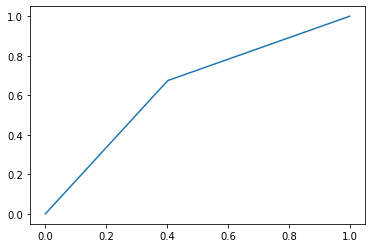

In [118]:
# sklearn에서 ROC 패키지 활용
fpr, tpr, thresholds = roc_curve(test_y,pred_y,pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

In [119]:
table_logit = logit[-10:]

In [120]:
table_logit['logit'] = pred_y[-10:]

In [121]:
ratio = results.predict_proba(test_x)[-10:] # [-1,1]

In [122]:
table_logit['up_ratio'] = 0.1
for i in range(10):
  table_logit['up_ratio'].iloc[i] = ratio[i][1] 

In [123]:
table_logit.to_csv('sk_logit_table.csv', index=False)

In [124]:
joblib.dump(results, 'logit_sk_model.pkl')

['logit_sk_model.pkl']

In [126]:
table_logit[:]

,const,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change,logit,up_ratio
523,1.0,660,2021-09-16,108920.065975,107550.482831,105246.881584,-1,0.577778,115.555556,0.789286,157.857143,0.385081,0.421872,0.50873,-1,1,0.620625
524,1.0,660,2021-09-17,107355.205464,104031.777745,105078.338157,0,0.500000,100.000000,0.305641,61.128205,0.243515,0.535122,0.50873,1,1,0.631255
525,1.0,660,2021-09-23,108519.868112,107116.509034,103850.692553,-1,0.500000,100.333333,0.471347,94.519481,0.461617,0.397960,0.50873,-1,1,0.543750
526,1.0,660,2021-09-24,107476.019812,105249.970974,103567.285211,1,0.186667,37.333333,0.457738,91.547619,0.079099,0.365010,0.50873,-1,-1,0.329881
527,1.0,660,2021-09-27,107726.805782,104093.305385,102325.908317,1,0.357143,71.428571,0.525683,105.367427,0.163172,0.365010,0.50873,1,-1,0.453850
528,1.0,660,2021-09-28,107043.387222,104730.352102,102359.063572,-1,0.403175,80.801587,0.282062,56.537338,0.326486,0.365010,0.50873,-1,1,0.537377
529,1.0,660,2021-09-29,107021.111012,103212.455833,101925.958867,0,0.357143,71.428571,0.350000,70.000000,0.284152,0.365010,0.50873,-1,-1,0.465369
530,1.0,660,2021-09-30,102079.786348,99956.289857,101804.451328,0,0.200000,40.000000,0.000000,0.000000,0.267341,0.495956,0.50873,1,-1,0.469111
531,1.0,660,2021-10-01,104292.145300,103483.507739,101463.377500,0,0.500000,100.000000,0.201225,40.495098,0.367717,0.965788,0.50873,-1,-1,0.424507
532,1.0,660,2021-10-05,102533.434129,99530.658878,100137.504683,1,0.515152,103.316017,0.368615,73.722944,0.224227,0.965788,0.50873,-1,-1,0.488966
